# Perform single-cell quality control

In this notebook, we perform single-cell quality control using [coSMicQC](https://github.com/WayScience/coSMicQC). 
We filter the single cells by identifying outliers with z-scores, and use either combinations of features or one feature for each condition. For more information on the functions, please refer [**here**](https://github.com/WayScience/coSMicQC/blob/main/src/cosmicqc/analyze.py).

NOTE: As this method uses z-scoring, there is an automatic assumption that the distribution of the features are normal. If they are not, this method will be less likely to work. We have confirmed the features we are using are of normal distribution.

We use the feature(s) below to assess the technical quality of the segmented single-cells:

### Assessing poor nuclei segmentation

To identify nuclei segmentations that include multiple nuclei, we use the following feature(s) as one condition:

- **Nuclei Solidity:** This metric quantifies how irregularly shaped a nuclei segmentation is. A value of 1 indicates that the segmentation is perfectly round and lower values indicate a very irregularly shaped nuclei (e.g., lot of indentation or protrusions).
- **Nuclei Integrated Intensity:** This metric quantifies the total intensity of all pixels in a nuclei segmentation. Higher values mean that there are likely more pixels which can indicate multiple nuclei within the segmentation.

To identify nuclei segmentations where the respective nuclei is over-saturated or undergoing mitosis, we use the following feature(s) as two more conditions.

- **Nuclei Upper Quartile Intensity:** This metric quantifies the distribution of the pixel intensities in which 75% of pixels fall below the value (capturing the top 25% of pixel intensities). Values near 1 from this metric indicate that most pixel intensities are at a very high value.
- **Nuclei MAD (Median Absolute Deviation) Intensity:** This metric quantifies the variability of pixel intensities within the nuclei. Higher values of this metric indicate more texture while very low values indicate very little differences between pixel intensities (e.g., low variance).

## Import libraries

In [1]:
import pathlib
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
import yaml

from cosmicqc import find_outliers
from cytodataframe import CytoDataFrame

## Define helper function

In [2]:
# helper function for CytoDataFrame to not change the brightness of the image
def do_not_adjust_image_brightness(image: Image.Image) -> Image.Image:
    """
    Function for CytoDataFrame to do nothing to the image and return it unchanged.

    Args:
        image (Image.Image): The input PIL Image.

    Returns:
        Image.Image: The unchanged PIL Image.
    """
    # Return the input image as is without any modifications
    return image

## Set paths and variables

In [3]:
# Directory with data
data_dir = pathlib.Path("./data/converted_data/").resolve(strict=True)

# Directory to save cleaned data
cleaned_dir = pathlib.Path("./data/cleaned_profiles/")
cleaned_dir.mkdir(exist_ok=True)

# Directory to save qc figures
qc_fig_dir = pathlib.Path("./qc_figures")
qc_fig_dir.mkdir(exist_ok=True)

# metadata columns to include in output data frame
metadata_columns = [
    "Image_Metadata_Plate",
    "plate_alias",
    "Image_Metadata_Well",
    "Image_Metadata_Site",
    "Metadata_Nuclei_Location_Center_X",
    "Metadata_Nuclei_Location_Center_Y",
    "Image_FileName_DAPI",
    "Image_PathName_DAPI",
    "Nuclei_AreaShape_BoundingBoxMaximum_X",
    "Nuclei_AreaShape_BoundingBoxMaximum_Y",
    "Nuclei_AreaShape_BoundingBoxMinimum_X",
    "Nuclei_AreaShape_BoundingBoxMinimum_Y",
]

# Path to dictionary
dictionary_path = pathlib.Path("./plate_info_dictionary.yaml")

## Load in dictionary of plates to process

In [4]:
# Load plate information from YAML file
with open(dictionary_path, "r") as file:
    plate_info = yaml.safe_load(file)

# Load in specific plates relevant to manuscript
plates = ["Plate_3_prime", "Plate_3", "Plate_5", "Plate_6"]

# Load in specified plates from plate_info_dictionary
plates = plate_info.keys()
dfs = {plate: pd.read_parquet(plate_info[plate]["dest_path"]) for plate in plates}

# Concatenate all dataframes into a single dataframe
combined_df = pd.concat(dfs.values(), ignore_index=True)

# Create a mapping for plate aliases
plate_alias_mapping = {
    "Plate_3": "Plate A",
    "Plate_3_prime": "Plate B",
    "Plate_5": "Plate C",
    "Plate_6": "Plate D",
}

# Add the plate_alias column
combined_df["plate_alias"] = combined_df["Image_Metadata_Plate"].map(
    plate_alias_mapping
)

# Print output
print(combined_df.shape)
combined_df.head()

(40480, 2322)


,Metadata_ImageNumber,Image_Metadata_Plate,Metadata_number_of_singlecells,Image_Metadata_Site,Image_Metadata_Well,Metadata_Cells_Number_Object_Number,Metadata_Cytoplasm_Parent_Cells,Metadata_Cytoplasm_Parent_Nuclei,Metadata_Nuclei_Number_Object_Number,Image_FileName_CY5,...,Nuclei_Texture_Variance_DAPI_3_03_256,Nuclei_Texture_Variance_GFP_3_00_256,Nuclei_Texture_Variance_GFP_3_01_256,Nuclei_Texture_Variance_GFP_3_02_256,Nuclei_Texture_Variance_GFP_3_03_256,Nuclei_Texture_Variance_RFP_3_00_256,Nuclei_Texture_Variance_RFP_3_01_256,Nuclei_Texture_Variance_RFP_3_02_256,Nuclei_Texture_Variance_RFP_3_03_256,plate_alias
0,2,Plate_3,84,11,B10,1,1,2,2,B10_01_3_11_CY5_001_illumcorrect.tiff,...,2928.440215,1289.387179,1113.191261,1143.798104,1229.706291,1860.427125,1792.018063,1751.963638,1860.317249,Plate A
1,5,Plate_3,84,14,B10,1,1,2,2,B10_01_3_14_CY5_001_illumcorrect.tiff,...,687.648994,38.764372,40.170070,40.270733,37.789788,101.849116,99.378570,99.875012,98.784846,Plate A
2,12,Plate_3,84,20,B10,1,1,2,2,B10_01_3_20_CY5_001_illumcorrect.tiff,...,1486.305372,279.656989,270.323458,300.199086,289.428542,189.134603,192.120194,188.116851,187.663065,Plate A
3,13,Plate_3,84,21,B10,1,1,2,2,B10_01_3_21_CY5_001_illumcorrect.tiff,...,546.635939,35.728497,37.452466,34.925836,34.609601,84.199793,86.931665,85.634432,82.349088,Plate A
4,14,Plate_3,84,22,B10,1,1,2,2,B10_01_3_22_CY5_001_illumcorrect.tiff,...,979.699936,85.783028,82.215142,84.944425,100.984105,226.980762,230.125834,230.609025,226.963522,Plate A


,Image_FileName_DAPI,Nuclei_Intensity_MADIntensity_DAPI,Nuclei_AreaShape_Solidity,Nuclei_Intensity_UpperQuartileIntensity_DAPI
27041,,0.041772,0.977385,0.272759
6158,,0.078141,0.976457,0.451118

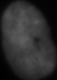
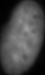

In [5]:
# Define the QC features
qc_features = [
    "Nuclei_Intensity_UpperQuartileIntensity_DAPI",
    "Nuclei_Intensity_IntegratedIntensity_DAPI",
    "Nuclei_Intensity_MADIntensity_DAPI",
    "Nuclei_AreaShape_Solidity",
]

# Filter combined_df to only include metadata columns and QC features
filtered_combined_df = combined_df[metadata_columns + qc_features]

filtered_combined_df_cdf = CytoDataFrame(
    data=filtered_combined_df, image_adjustment=do_not_adjust_image_brightness
)[
    [
        "Image_FileName_DAPI",
        "Nuclei_Intensity_MADIntensity_DAPI",
        "Nuclei_AreaShape_Solidity",
        "Nuclei_Intensity_UpperQuartileIntensity_DAPI",
    ]
]

# Sample 2 rows from the dataframe
filtered_combined_df_cdf.sample(n=2, random_state=0)

## Over-saturated nuclei (mitosis/debris)

NOTE: Threshold was determined with trial and error to find where the cutoff for good to bad quality or mitosis-ing single-cells are.

Number of outliers: 2224 (5.49%)
Outliers Range:
Nuclei_Intensity_UpperQuartileIntensity_DAPI Min: 0.9674372673034668
Nuclei_Intensity_UpperQuartileIntensity_DAPI Max: 0.9970397353172302
(2224, 2)


,Nuclei_Intensity_UpperQuartileIntensity_DAPI,Image_FileName_DAPI
5925,0.967437,
11009,0.967445,

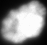
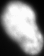

In [6]:
# Set outlier threshold that maximizes removing most technical outliers and minimizes good cells
outlier_threshold = 2

# find nuclei with overly high intensity (over-saturated)
feature_thresholds = {
    "Nuclei_Intensity_UpperQuartileIntensity_DAPI": outlier_threshold,
}

nuclei_high_int_outliers = find_outliers(
    df=filtered_combined_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

nuclei_high_int_outliers_cdf = CytoDataFrame(
    data=nuclei_high_int_outliers, image_adjustment=do_not_adjust_image_brightness
)[
    [
        "Nuclei_Intensity_UpperQuartileIntensity_DAPI",
        "Image_FileName_DAPI",
    ]
]

# Sort the outliers
nuclei_high_int_outliers_cdf = nuclei_high_int_outliers_cdf.sort_values(
    by="Nuclei_Intensity_UpperQuartileIntensity_DAPI", ascending=True
)

print(nuclei_high_int_outliers_cdf.shape)
nuclei_high_int_outliers_cdf.head(2)

,Nuclei_Intensity_UpperQuartileIntensity_DAPI,Image_FileName_DAPI
10393,0.983093,
33888,0.993027,

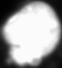
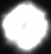

In [7]:
nuclei_high_int_outliers_cdf.sample(n=2, random_state=0)

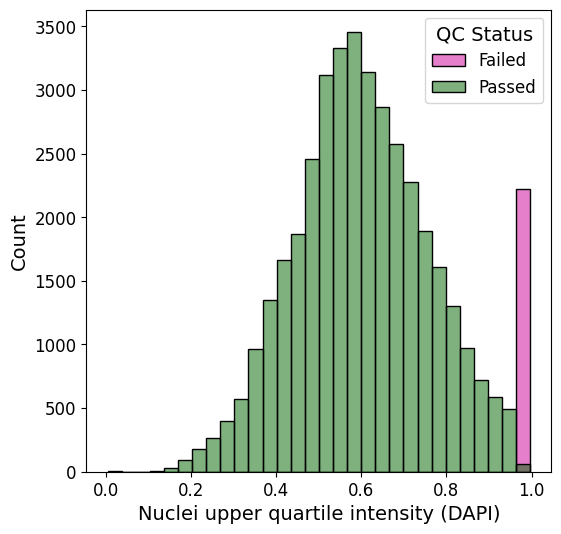

In [8]:
# Create a new column 'qc_status' in filtered_combined_df
copy_filtered_combined_df = filtered_combined_df.copy()
copy_filtered_combined_df["qc_status"] = copy_filtered_combined_df.index.map(
    lambda idx: "Failed" if idx in nuclei_high_int_outliers.index else "Passed"
)

# Set figure size
plt.figure(figsize=(6, 6))

# Histogram plot for nuclei high intensity outliers, grouped by qc_status
sns.histplot(
    data=copy_filtered_combined_df,
    x="Nuclei_Intensity_UpperQuartileIntensity_DAPI",
    hue="qc_status",  # Color bins by qc_status
    multiple="layer",  # Stack the bars for better comparison
    bins=30,  # Adjust the number of bins as needed
    kde=False,  # Disable KDE
    palette={
        "Passed": "#006400",
        "Failed": "#CC0099",
    },  # Custom colors for Passed and Failed
    legend=False,
)

# Customize the plot
plt.xlabel("Nuclei upper quartile intensity (DAPI)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(
    title="QC Status",
    loc="upper right",
    labels=["Failed", "Passed"],
    fontsize=12,
    title_fontsize=14,
)

plt.savefig(
    qc_fig_dir / "high_intensity_nuclei_outliers_histogram.png",
    dpi=500,
    bbox_inches="tight",
)

# Show the plot
plt.show()

In [9]:
# Print out the number of outliers across plates
outlier_counts = nuclei_high_int_outliers["Image_Metadata_Plate"].value_counts()

# Calculate the percentage of outliers
total_counts = combined_df["Image_Metadata_Plate"].value_counts()
outlier_percentages = (outlier_counts / total_counts) * 100

# Print the counts and percentages
for plate, count in outlier_counts.items():
    print(f"{plate}: {count} outliers ({outlier_percentages[plate]:.2f}%)")

Plate_3: 1270 outliers (7.04%)
Plate_3_prime: 471 outliers (6.45%)
Plate_6: 253 outliers (3.43%)
Plate_5: 230 outliers (2.96%)


Number of outliers: 1684 (4.16%)
Outliers Range:
Nuclei_Intensity_MADIntensity_DAPI Min: 0.1616235375404358
Nuclei_Intensity_MADIntensity_DAPI Max: 0.38999007642269135
(1684, 2)


,Nuclei_Intensity_MADIntensity_DAPI,Image_FileName_DAPI
1270,0.161624,
36001,0.161639,

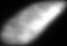
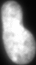

In [10]:
# Set outlier threshold that maximizes removing most technical outliers and minimizes good cells
outlier_threshold = 2

# find nuclei with overly high intensity (over-saturated)
feature_thresholds = {
    "Nuclei_Intensity_MADIntensity_DAPI": outlier_threshold,
}

blurry_nuclei_outliers = find_outliers(
    df=filtered_combined_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

blurry_nuclei_outliers_cdf = CytoDataFrame(
    data=blurry_nuclei_outliers, image_adjustment=do_not_adjust_image_brightness
)[
    [
        "Nuclei_Intensity_MADIntensity_DAPI",
        "Image_FileName_DAPI",
    ]
]

# Sort the outliers
blurry_nuclei_outliers_cdf = blurry_nuclei_outliers_cdf.sort_values(
    by="Nuclei_Intensity_MADIntensity_DAPI", ascending=True
)

print(blurry_nuclei_outliers_cdf.shape)
blurry_nuclei_outliers_cdf.head(2)

,Nuclei_Intensity_MADIntensity_DAPI,Image_FileName_DAPI
28634,0.162303,
3109,0.167391,

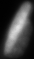
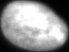

In [11]:
blurry_nuclei_outliers_cdf.sample(n=2, random_state=0)

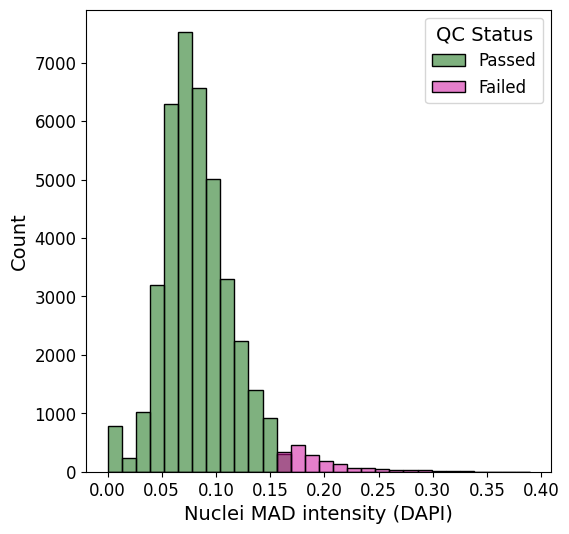

In [12]:
# Create a new column 'qc_status' in filtered_combined_df
copy_filtered_combined_df = filtered_combined_df.copy()
copy_filtered_combined_df["qc_status"] = copy_filtered_combined_df.index.map(
    lambda idx: "Failed" if idx in blurry_nuclei_outliers.index else "Passed"
)

# Set figure size
plt.figure(figsize=(6, 6))

# Histogram plot for blurry nuclei outliers, grouped by qc_status
sns.histplot(
    data=copy_filtered_combined_df,
    x="Nuclei_Intensity_MADIntensity_DAPI",
    hue="qc_status",  # Color bins by qc_status
    multiple="layer",  # Stack the bars for better comparison
    bins=30,  # Adjust the number of bins as needed
    kde=False,  # Disable KDE
    palette={
        "Passed": "#006400",
        "Failed": "#CC0099",
    },  # Custom colors for Passed and Failed
    legend=False,
)

# Customize the plot
plt.xlabel("Nuclei MAD intensity (DAPI)", fontsize=14)
plt.ylabel("Count", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(
    title="QC Status",
    loc="upper right",
    labels=["Passed", "Failed"],
    fontsize=12,
    title_fontsize=14,
)

plt.savefig(
    qc_fig_dir / "blurry_nuclei_outliers_histogram.png",
    dpi=500,
    bbox_inches="tight",
)

# Show the plot
plt.show()

In [13]:
# Print out the number of outliers across plates
outlier_counts = blurry_nuclei_outliers["Image_Metadata_Plate"].value_counts()

# Calculate the percentage of outliers
total_counts = combined_df["Image_Metadata_Plate"].value_counts()
outlier_percentages = (outlier_counts / total_counts) * 100

# Print the counts and percentages
for plate, count in outlier_counts.items():
    print(f"{plate}: {count} outliers ({outlier_percentages[plate]:.2f}%)")

Plate_3: 752 outliers (4.17%)
Plate_5: 478 outliers (6.16%)
Plate_6: 285 outliers (3.86%)
Plate_3_prime: 169 outliers (2.32%)


## Over-segmented nuclei (reflected by irregular, non-circular shape)

NOTE: Threshold was determined with trial and error to find where the cutoff for good to bad quality single-cell are.

Number of outliers: 253 (0.62%)
Outliers Range:
Nuclei_AreaShape_Solidity Min: 0.6854616444648599
Nuclei_AreaShape_Solidity Max: 0.9381644223954642
Nuclei_Intensity_IntegratedIntensity_DAPI Min: 2683.4669263213873
Nuclei_Intensity_IntegratedIntensity_DAPI Max: 5026.981560587883
(253, 6)


,Nuclei_AreaShape_Solidity,Nuclei_Intensity_IntegratedIntensity_DAPI,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Image_FileName_DAPI
1939,0.938164,3490.844313,Plate_3,B12,17,
20420,0.938127,4421.816195,Plate_3_prime,E12,24,

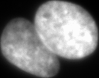
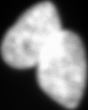

In [14]:
# find irregular shaped nuclei
feature_thresholds = {
    "Nuclei_AreaShape_Solidity": -1.25, # outlier threshold for only solidity (values less than the mean)
    "Nuclei_Intensity_IntegratedIntensity_DAPI": 2, # outlier threshold for only intensity (values above than the mean)
}

irregular_nuclei_outliers = find_outliers(
    df=filtered_combined_df,
    metadata_columns=metadata_columns,
    feature_thresholds=feature_thresholds,
)

irregular_nuclei_outliers_cdf = CytoDataFrame(
    data=irregular_nuclei_outliers, image_adjustment=do_not_adjust_image_brightness
)[
    [
        "Nuclei_AreaShape_Solidity",
        "Nuclei_Intensity_IntegratedIntensity_DAPI",
        "Image_Metadata_Plate",
        "Image_Metadata_Well",
        "Image_Metadata_Site",
        "Image_FileName_DAPI",
    ]
]

print(irregular_nuclei_outliers_cdf.shape)
irregular_nuclei_outliers_cdf.sort_values(
    by="Nuclei_AreaShape_Solidity", ascending=False
).head(2)

,Nuclei_AreaShape_Solidity,Nuclei_Intensity_IntegratedIntensity_DAPI,Image_Metadata_Plate,Image_Metadata_Well,Image_Metadata_Site,Image_FileName_DAPI
18684,0.906931,2982.056566,Plate_3_prime,E1,18,
12365,0.912802,4125.289737,Plate_3,C4,5,

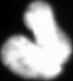
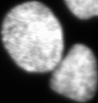

In [15]:
irregular_nuclei_outliers_cdf.sample(n=2, random_state=0)

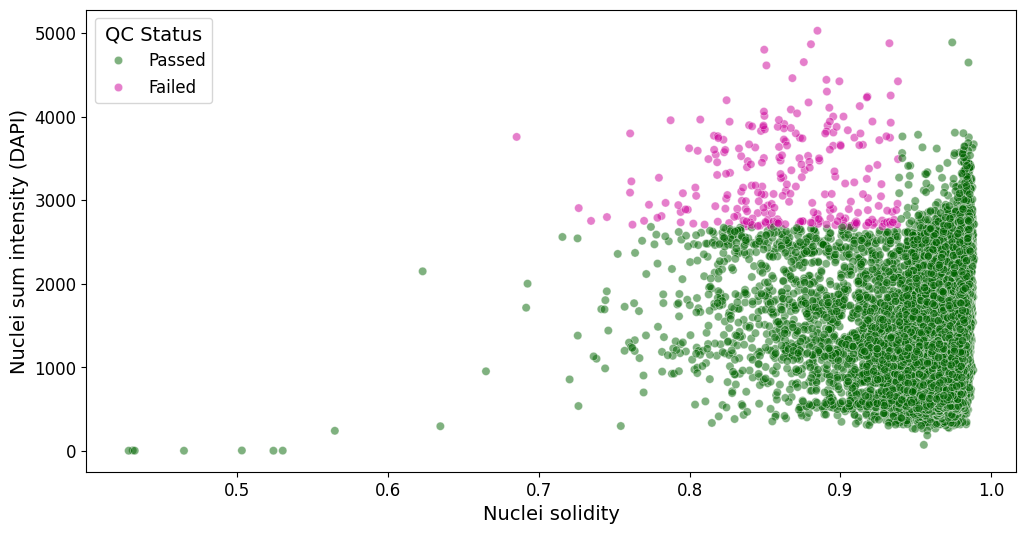

In [16]:
# Create a new column 'qc_status' in filtered_combined_df
copy_filtered_combined_df = filtered_combined_df.copy()
copy_filtered_combined_df["qc_status"] = copy_filtered_combined_df.index.map(
    lambda idx: "Failed" if idx in irregular_nuclei_outliers.index else "Passed"
)

# Set figure size
plt.figure(figsize=(12, 6))

# Scatterplot for intensity and solidity in the DataFrame
ax = sns.scatterplot(
    data=copy_filtered_combined_df,
    x="Nuclei_AreaShape_Solidity",
    y="Nuclei_Intensity_IntegratedIntensity_DAPI",
    hue="qc_status",  # Color points by qc_status
    alpha=0.5,  # Set transparency for better visibility
    palette={
        "Passed": "#006400",
        "Failed": "#CC0099",
    },  # Custom colors for Passed and Failed
)

# Customize the plot
plt.xlabel("Nuclei solidity", fontsize=14)
plt.ylabel("Nuclei sum intensity (DAPI)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Retrieve handles and labels correctly
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles,
    labels=labels,
    title="QC Status",
    loc="upper left",
    fontsize=12,
    title_fontsize=14,
)

plt.savefig(
    qc_fig_dir / "irregular_nuclei_outliers_scatterplot.png",
    dpi=500,
    bbox_inches="tight",
)

# Show the plot
plt.show()

In [17]:
# Print out the number of outliers across plates
outlier_counts = irregular_nuclei_outliers["Image_Metadata_Plate"].value_counts()

# Calculate the percentage of outliers
total_counts = combined_df["Image_Metadata_Plate"].value_counts()
outlier_percentages = (outlier_counts / total_counts) * 100

# Print the counts and percentages
for plate, count in outlier_counts.items():
    print(f"{plate}: {count} outliers ({outlier_percentages[plate]:.2f}%)")

Plate_3: 154 outliers (0.85%)
Plate_3_prime: 63 outliers (0.86%)
Plate_6: 28 outliers (0.38%)
Plate_5: 8 outliers (0.10%)


In [18]:
# Remove outliers from combined_df
outlier_indices = nuclei_high_int_outliers.index.union(
    irregular_nuclei_outliers.index
).union(blurry_nuclei_outliers.index)
dropped_outliers_combined_df = combined_df.drop(outlier_indices)
print(dropped_outliers_combined_df.shape[0])

36746


In [19]:
# Collect the indices of the outliers
outlier_indices = pd.concat(
    [nuclei_high_int_outliers, irregular_nuclei_outliers, blurry_nuclei_outliers]
).index

# Remove rows with outlier indices from combined_df
combined_df_cleaned = combined_df.drop(outlier_indices)

# Save cleaned data for each plate and update the dictionary with cleaned paths
for plate in plates:
    plate_df = combined_df[
        combined_df["Image_Metadata_Plate"] == plate
    ]  # Original plate data
    plate_df_cleaned = combined_df_cleaned[
        combined_df_cleaned["Image_Metadata_Plate"] == plate
    ]  # Cleaned plate data

    # Calculate number of failed cells (rows removed)
    failed_cells = plate_df.shape[0] - plate_df_cleaned.shape[0]

    # Calculate percentage of failed cells
    failed_percentage = (failed_cells / plate_df.shape[0]) * 100

    # Print the number of failed cells and the percentage
    print(f"{plate}: {failed_cells} cells failed ({failed_percentage:.2f}% failed)")

    # Clean the plate data
    plate_df_cleaned = plate_df_cleaned.drop(
        columns=["plate_alias"]
    )  # Remove plate_alias column

    # Save cleaned data for each plate
    cleaned_path = f"{cleaned_dir}/{plate}_cleaned.parquet"
    plate_df_cleaned.to_parquet(cleaned_path)
    plate_info[plate]["cleaned_path"] = cleaned_path
    print(plate, ":", plate_df_cleaned.shape)

Plate_3: 1945 cells failed (10.78% failed)
Plate_3 : (16093, 2321)
Plate_3_prime: 649 cells failed (8.89% failed)
Plate_3_prime : (6651, 2321)
Plate_5: 619 cells failed (7.98% failed)
Plate_5 : (7140, 2321)
Plate_6: 521 cells failed (7.06% failed)
Plate_6 : (6862, 2321)


## Dump the new cleaned path to the dictionary for downstream processing

In [20]:
with open(dictionary_path, "w") as file:
    yaml.dump(plate_info, file)